### Step 1. KITTI 데이터셋 수집과 구축

### Imports

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

### 1) 데이터 확인

In [2]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

train_paths = glob(os.path.join(dir_path, 'semantic', '*'))
train_paths[:5]

['/home/aiffel-dj51/aiffel/semantic_segmentation/data/training/semantic/000045_10.png',
 '/home/aiffel-dj51/aiffel/semantic_segmentation/data/training/semantic/000030_10.png',
 '/home/aiffel-dj51/aiffel/semantic_segmentation/data/training/semantic/000000_10.png',
 '/home/aiffel-dj51/aiffel/semantic_segmentation/data/training/semantic/000008_10.png',
 '/home/aiffel-dj51/aiffel/semantic_segmentation/data/training/semantic/000074_10.png']

In [3]:
check_path = train_paths[0]
seg = Image.open(check_path)
seg_arr = np.array(seg)
classes = np.unique(seg_arr)
classes, len(classes)

(array([ 4,  7,  8, 10, 11, 15, 17, 19, 20, 21, 22, 23, 26], dtype=uint8), 13)

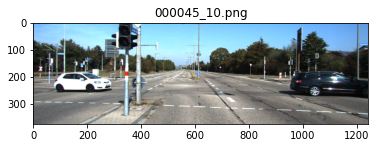

In [4]:
origin_img_paths = glob(os.path.join(dir_path, 'image_2', '*'))

origin_img_path = os.path.join(dir_path, 'image_2', check_path.split('/')[-1])
if os.path.exists(origin_img_path) :
    img = Image.open(origin_img_path)
    img_arr = np.array(img)
    plt.imshow(img_arr)
    plt.title(check_path.split('/')[-1])
    plt.show()

In [5]:
len(classes)

13

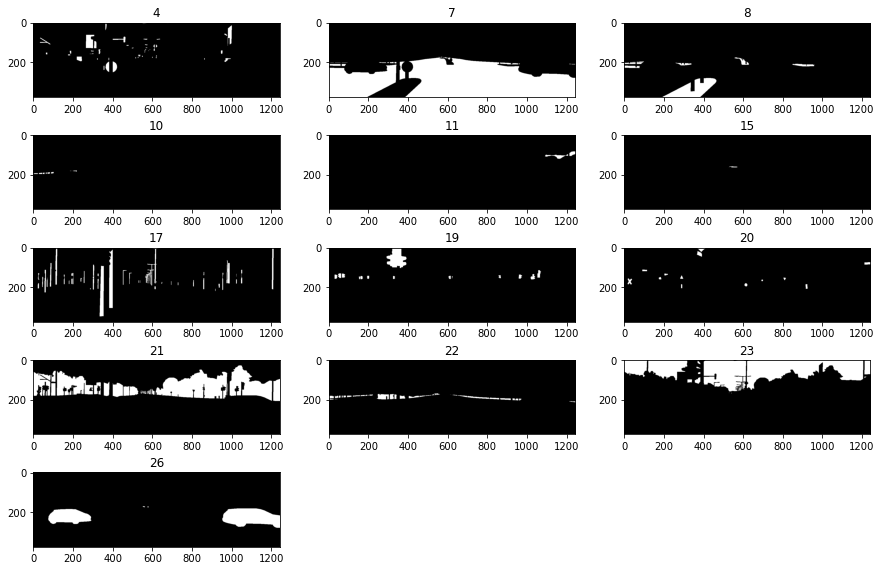

In [7]:
i = 0
plt.figure(figsize=(15, 10))
for class_ in classes :
    i += 1
    plt.subplot(5, 3, i)
    plt.imshow(np.where(seg_arr==class_, 255, 0), 'gray')
    plt.title(class_)
plt.show()

### 2) 데이터 로더 만들기

#### Albumentation을 활용, Data Augmentation¶

In [8]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

#### augmentation 적용한 데이터 확인¶

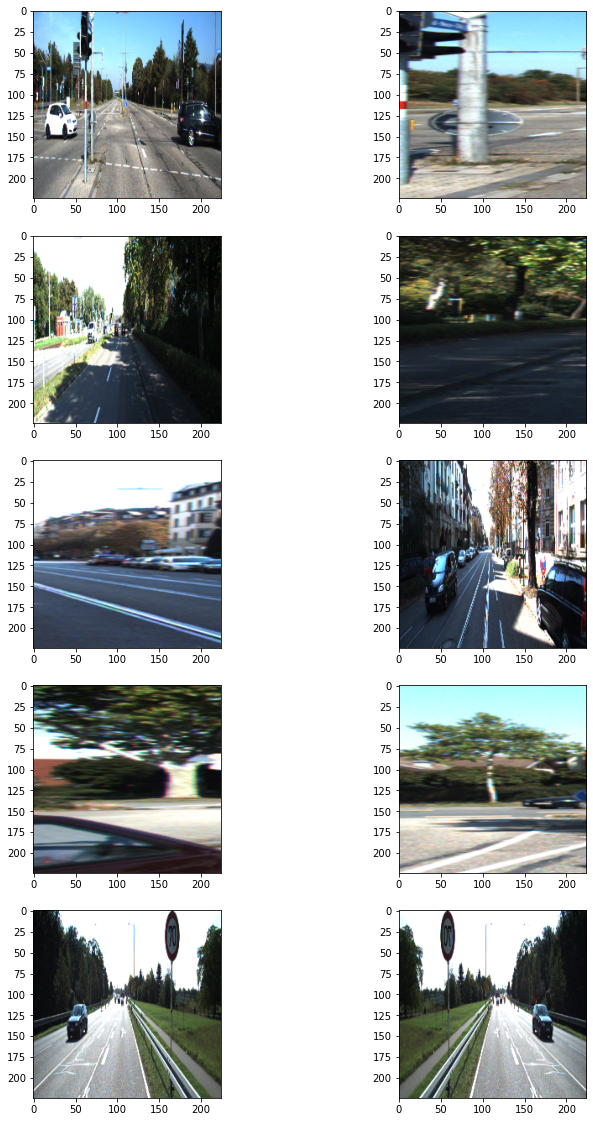

In [9]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

### 3) Generator 구현

In [10]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size
    
    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [11]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    batch_size=8,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    batch_size=8,
    augmentation=test_preproc,
    is_train=False
)

In [12]:
next(iter(train_generator))[0].shape

(8, 224, 224, 3)

In [13]:
next(iter(train_generator))[1].shape

(8, 224, 224)

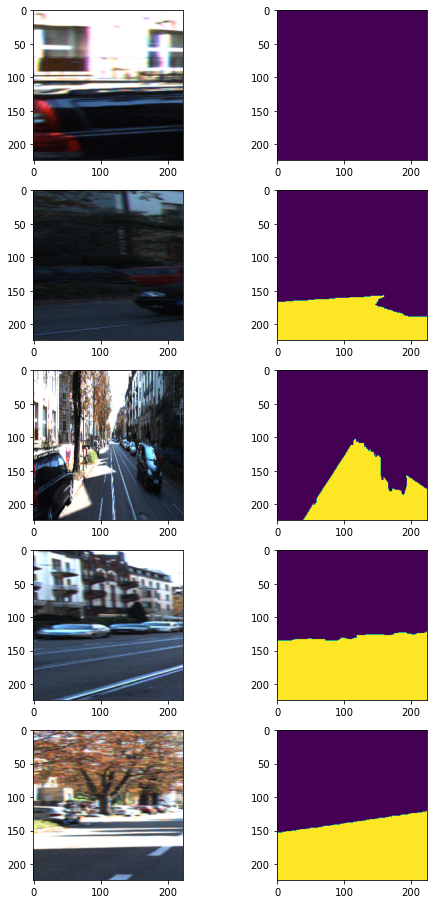

In [14]:
plt.figure(figsize=(8, 16))
for i in range(5) :
    data = next(iter(train_generator))
    
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(data[0][0, :, :])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(data[1][0, :, :])
plt.show()

### Step 2. U-Net++ 모델의 구현

### 1) U-Net 구현 및 학습

In [37]:
def build_UNet(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # size 줄음

    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # size 줄음

    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  # size 줄음

    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)  # size 줄음

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [38]:
unet = build_UNet()
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 224, 224, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_52[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_53[0][0]                  
____________________________________________________________________________________________

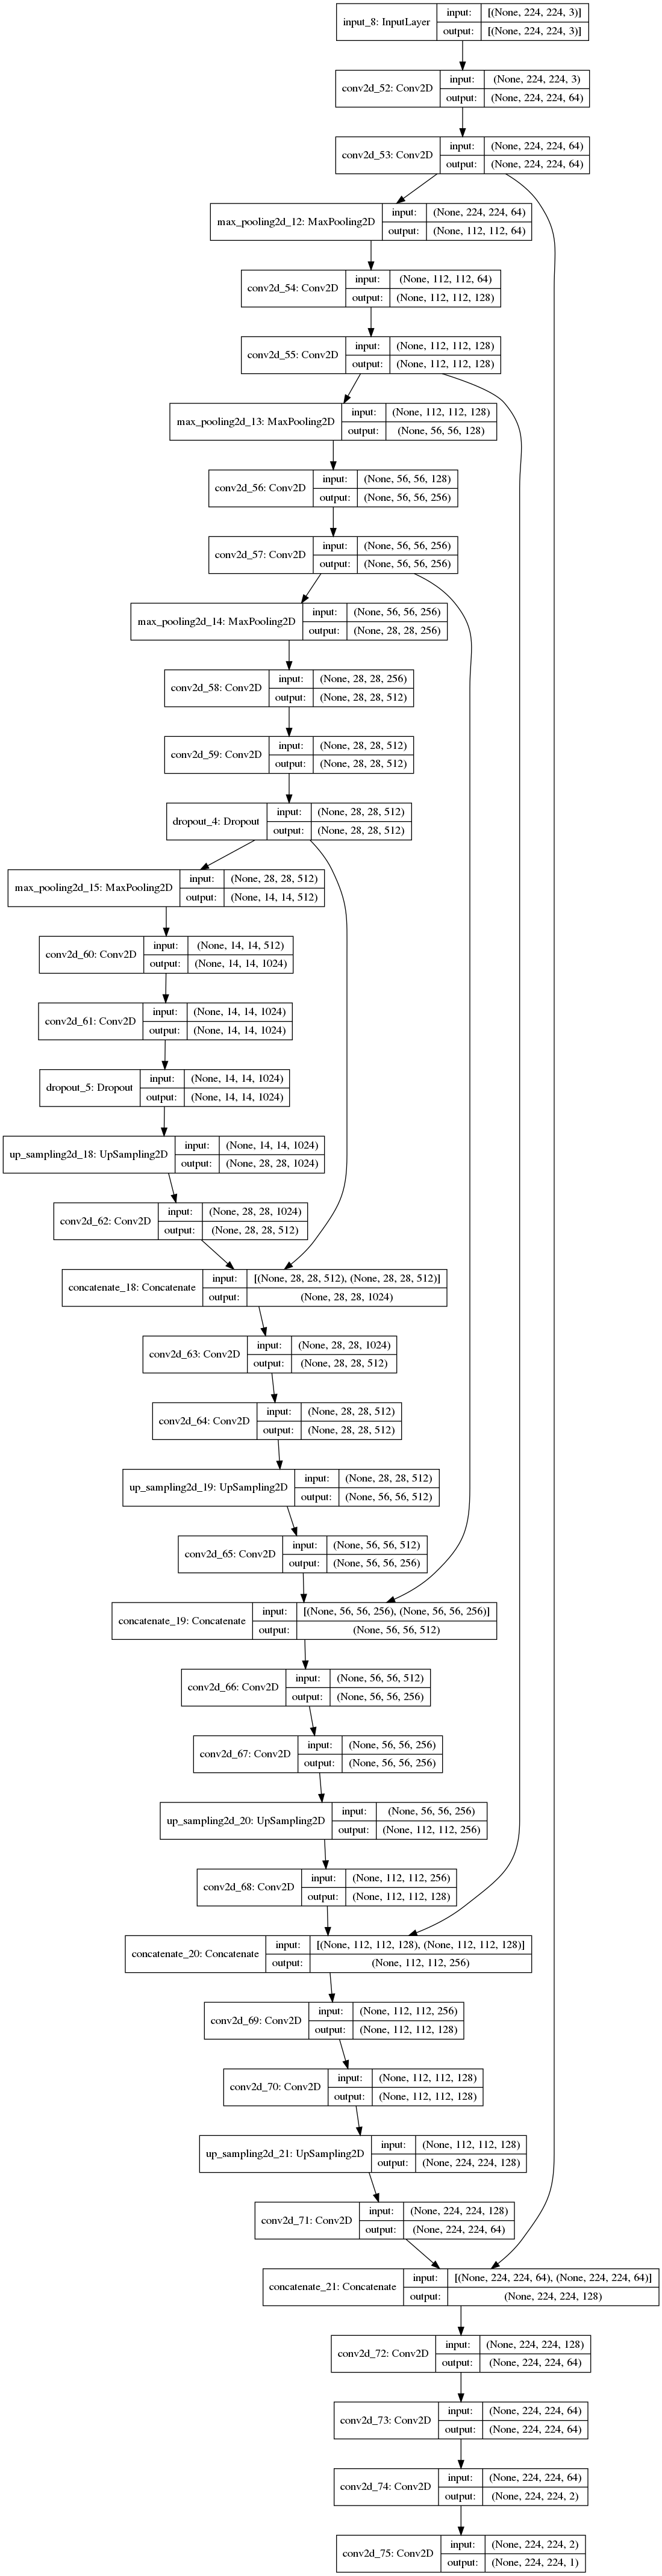

In [39]:
tf.keras.utils.plot_model(unet, './UNet.png', show_shapes=True)

In [41]:
unet.compile(
    optimizer = Adam(lr=1e-4),
    loss = 'binary_crossentropy'
             )
unet.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)

Epoch 1/100
22/22 [==============================] - 8s 330ms/step - loss: 0.7064 - val_loss: 0.0922
Epoch 2/100
22/22 [==============================] - 7s 318ms/step - loss: 0.0743 - val_loss: 0.0490
Epoch 3/100
22/22 [==============================] - 7s 319ms/step - loss: 0.0537 - val_loss: 0.0456
Epoch 4/100
22/22 [==============================] - 7s 321ms/step - loss: 0.0484 - val_loss: 0.0552
Epoch 5/100
22/22 [==============================] - 7s 324ms/step - loss: 0.0475 - val_loss: 0.0499
Epoch 6/100
22/22 [==============================] - 7s 325ms/step - loss: 0.0461 - val_loss: 0.0496
Epoch 7/100
22/22 [==============================] - 7s 327ms/step - loss: 0.0425 - val_loss: 0.0494
Epoch 8/100
22/22 [==============================] - 7s 328ms/step - loss: 0.0825 - val_loss: 0.0438
Epoch 9/100
22/22 [==============================] - 7s 329ms/step - loss: 0.0382 - val_loss: 0.0386
Epoch 10/100
22/22 [==============================] - 7s 329ms/step - loss: 0.0366 - val_lo

22/22 [==============================] - 7s 326ms/step - loss: 0.0402 - val_loss: 0.0429
Epoch 82/100
22/22 [==============================] - 7s 325ms/step - loss: 0.0350 - val_loss: 0.0352
Epoch 83/100
22/22 [==============================] - 7s 325ms/step - loss: 0.0275 - val_loss: 0.0357
Epoch 84/100
22/22 [==============================] - 7s 325ms/step - loss: 0.0275 - val_loss: 0.0369
Epoch 85/100
22/22 [==============================] - 7s 325ms/step - loss: 0.0344 - val_loss: 0.0370
Epoch 86/100
22/22 [==============================] - 7s 325ms/step - loss: 0.0322 - val_loss: 0.0353
Epoch 87/100
22/22 [==============================] - 7s 325ms/step - loss: 0.0337 - val_loss: 0.0351
Epoch 88/100
22/22 [==============================] - 7s 325ms/step - loss: 0.0319 - val_loss: 0.0349
Epoch 89/100
22/22 [==============================] - 7s 325ms/step - loss: 0.0351 - val_loss: 0.0441
Epoch 90/100
22/22 [==============================] - 7s 325ms/step - loss: 0.0368 - val_loss: 

In [26]:
unet.save('./unet.h5')
del unet

### 2) U-Net++ 구현 및 학습

In [27]:
def build_UNet_Plus(input_shape=(224, 224, 3), n = 32) :
    
    filters = [n, n*2, n*4, n*8, n*16]
    
    inputs = Input(input_shape)
    
    #conv0_0
    conv001 = Conv2D(filters=filters[0], kernel_size=3, padding='same', kernel_initializer='he_normal', name='conv0_0_1')(inputs)
    bn001 = BatchNormalization()(conv001)
    act001 = Activation('relu')(bn001)
    conv002 = Conv2D(filters=filters[0], kernel_size=3, padding='same', kernel_initializer='he_normal', name='conv0_0_2')(act001)
    bn002 = BatchNormalization()(conv002)
    conv00 = Activation('relu')(bn002)
    
    #conv1_0
    conv00_down = MaxPooling2D(strides=2)(conv00)
    conv101 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_1')(conv00_down)
    bn101 = BatchNormalization()(conv101)
    act101 = Activation('relu')(bn101)
    conv102 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_0_2')(act101)
    bn102 = BatchNormalization()(conv102)
    conv10 = Activation('relu')(bn102)
    
    #conv2_0
    conv10_down = MaxPooling2D(strides=2)(conv10)
    conv201 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_1')(conv10_down)
    bn201 = BatchNormalization()(conv201)
    act201 = Activation('relu')(bn201)
    conv202 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_0_2')(act201)
    bn202 = BatchNormalization()(conv202)
    conv20 = Activation('relu')(bn202)
    
    #conv3_0
    conv20_down = MaxPooling2D(strides=2)(conv20)
    conv301 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_1')(conv20_down)
    bn301 = BatchNormalization()(conv301)
    act301 = Activation('relu')(bn301)
    conv302 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_0_2')(act301)
    bn302 = BatchNormalization()(conv302)
    conv30 = Activation('relu')(bn302)
    
    #conv4_0
    conv30_down = MaxPooling2D(strides=2)(conv30)
    conv401 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_1')(conv30_down)
    bn401 = BatchNormalization()(conv401)
    act401 = Activation('relu')(bn401)
    conv402 = Conv2D(filters[4], 3, padding='same', kernel_initializer='he_normal', name='conv4_0_2')(act401)
    bn402 = BatchNormalization()(conv402)
    conv40 = Activation('relu')(bn402)
    
    
    
    #conv0_1
    conv10_up = UpSampling2D()(conv10)
    conv01_in = Concatenate()([conv00, conv10_up])
    
    conv011 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_1')(conv01_in)
    bn011 = BatchNormalization()(conv011)
    act011 = Activation('relu')(bn011)
    conv012 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_1_2')(act011)
    bn012 = BatchNormalization()(conv012)
    conv01 = Activation('relu')(bn012)
    
    #conv1_1
    conv20_up = UpSampling2D()(conv20)
    conv11_in = Concatenate()([conv10, conv20_up])
    
    conv111 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_1')(conv11_in)
    bn111 = BatchNormalization()(conv111)
    act111 = Activation('relu')(bn111)
    conv112 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_1_2')(act111)
    bn112 = BatchNormalization()(conv112)
    conv11 = Activation('relu')(bn112)
    
    #conv2_1
    conv30_up = UpSampling2D()(conv30)
    conv21_in = Concatenate()([conv20, conv30_up])
    
    conv211 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_1')(conv21_in)
    bn211 = BatchNormalization()(conv211)
    act211 = Activation('relu')(bn211)
    conv212 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_1_2')(act211)
    bn212 = BatchNormalization()(conv212)
    conv21 = Activation('relu')(bn212)
    
    #conv3_1
    conv40_up = UpSampling2D()(conv40)
    conv31_in = Concatenate()([conv30, conv40_up])
    
    conv311 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_1')(conv31_in)
    bn311 = BatchNormalization()(conv311)
    act311 = Activation('relu')(bn311)
    conv312 = Conv2D(filters[3], 3, padding='same', kernel_initializer='he_normal', name='conv3_1_2')(act311)
    bn312 = BatchNormalization()(conv312)
    conv31 = Activation('relu')(bn312)
    
    
    
    #conv0_2
    conv11_up = UpSampling2D()(conv11)
    conv02_in = Concatenate()([conv00, conv01, conv11_up])
    
    conv021 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_1')(conv02_in)
    bn021 = BatchNormalization()(conv021)
    act021 = Activation('relu')(bn021)
    conv022 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_2_2')(act021)
    bn022 = BatchNormalization()(conv022)
    conv02 = Activation('relu')(bn022)
    
    #conv1_2
    conv21_up = UpSampling2D()(conv21)
    conv12_in = Concatenate()([conv10, conv11, conv21_up])
    
    conv121 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_1')(conv12_in)
    bn121 = BatchNormalization()(conv121)
    act121 = Activation('relu')(bn121)
    conv122 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_2_2')(act121)
    bn122 = BatchNormalization()(conv122)
    conv12 = Activation('relu')(bn122)
    
    #conv2_2
    conv31_up = UpSampling2D()(conv31)
    conv22_in = Concatenate()([conv20, conv21, conv31_up])
    
    conv221 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_1')(conv22_in)
    bn221 = BatchNormalization()(conv221)
    act221 = Activation('relu')(bn221)
    conv222 = Conv2D(filters[2], 3, padding='same', kernel_initializer='he_normal', name='conv2_2_2')(act221)
    bn222 = BatchNormalization()(conv222)
    conv22 = Activation('relu')(bn222)
    
    
    
    #conv0_3
    conv12_up = UpSampling2D()(conv12)
    conv03_in = Concatenate()([conv00, conv01, conv02, conv12_up])
    
    conv031 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_1')(conv03_in)
    bn031 = BatchNormalization()(conv031)
    act031 = Activation('relu')(bn031)
    conv032 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_3_2')(act031)
    bn032 = BatchNormalization()(conv032)
    conv03 = Activation('relu')(bn032)

    #conv1_3
    conv22_up = UpSampling2D()(conv22)
    conv13_in = Concatenate()([conv10, conv11, conv12, conv22_up])
    
    conv131 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_1')(conv13_in)
    bn131 = BatchNormalization()(conv131)
    act131 = Activation('relu')(bn131)
    conv132 = Conv2D(filters[1], 3, padding='same', kernel_initializer='he_normal', name='conv1_3_2')(act131)
    bn132 = BatchNormalization()(conv132)
    conv13 = Activation('relu')(bn132)
    
    
    
    #conv0_4
    conv13_up = UpSampling2D()(conv13)
    conv04_in = Concatenate()([conv00, conv01, conv02, conv03, conv13_up])
    
    conv041 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_1')(conv04_in)
    bn041 = BatchNormalization()(conv041)
    act041 = Activation('relu')(bn041)
    conv042 = Conv2D(filters[0], 3, padding='same', kernel_initializer='he_normal', name='conv0_4_2')(act041)
    bn042 = BatchNormalization()(conv042)
    conv04 = Activation('relu')(bn042)
    
    output = Conv2D(1, 1, activation='sigmoid', name='final')(conv04)
    
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [28]:
unet_pp = build_UNet_Plus()

In [29]:
unet_pp.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0_0_1 (Conv2D)              (None, 224, 224, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv0_0_1[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

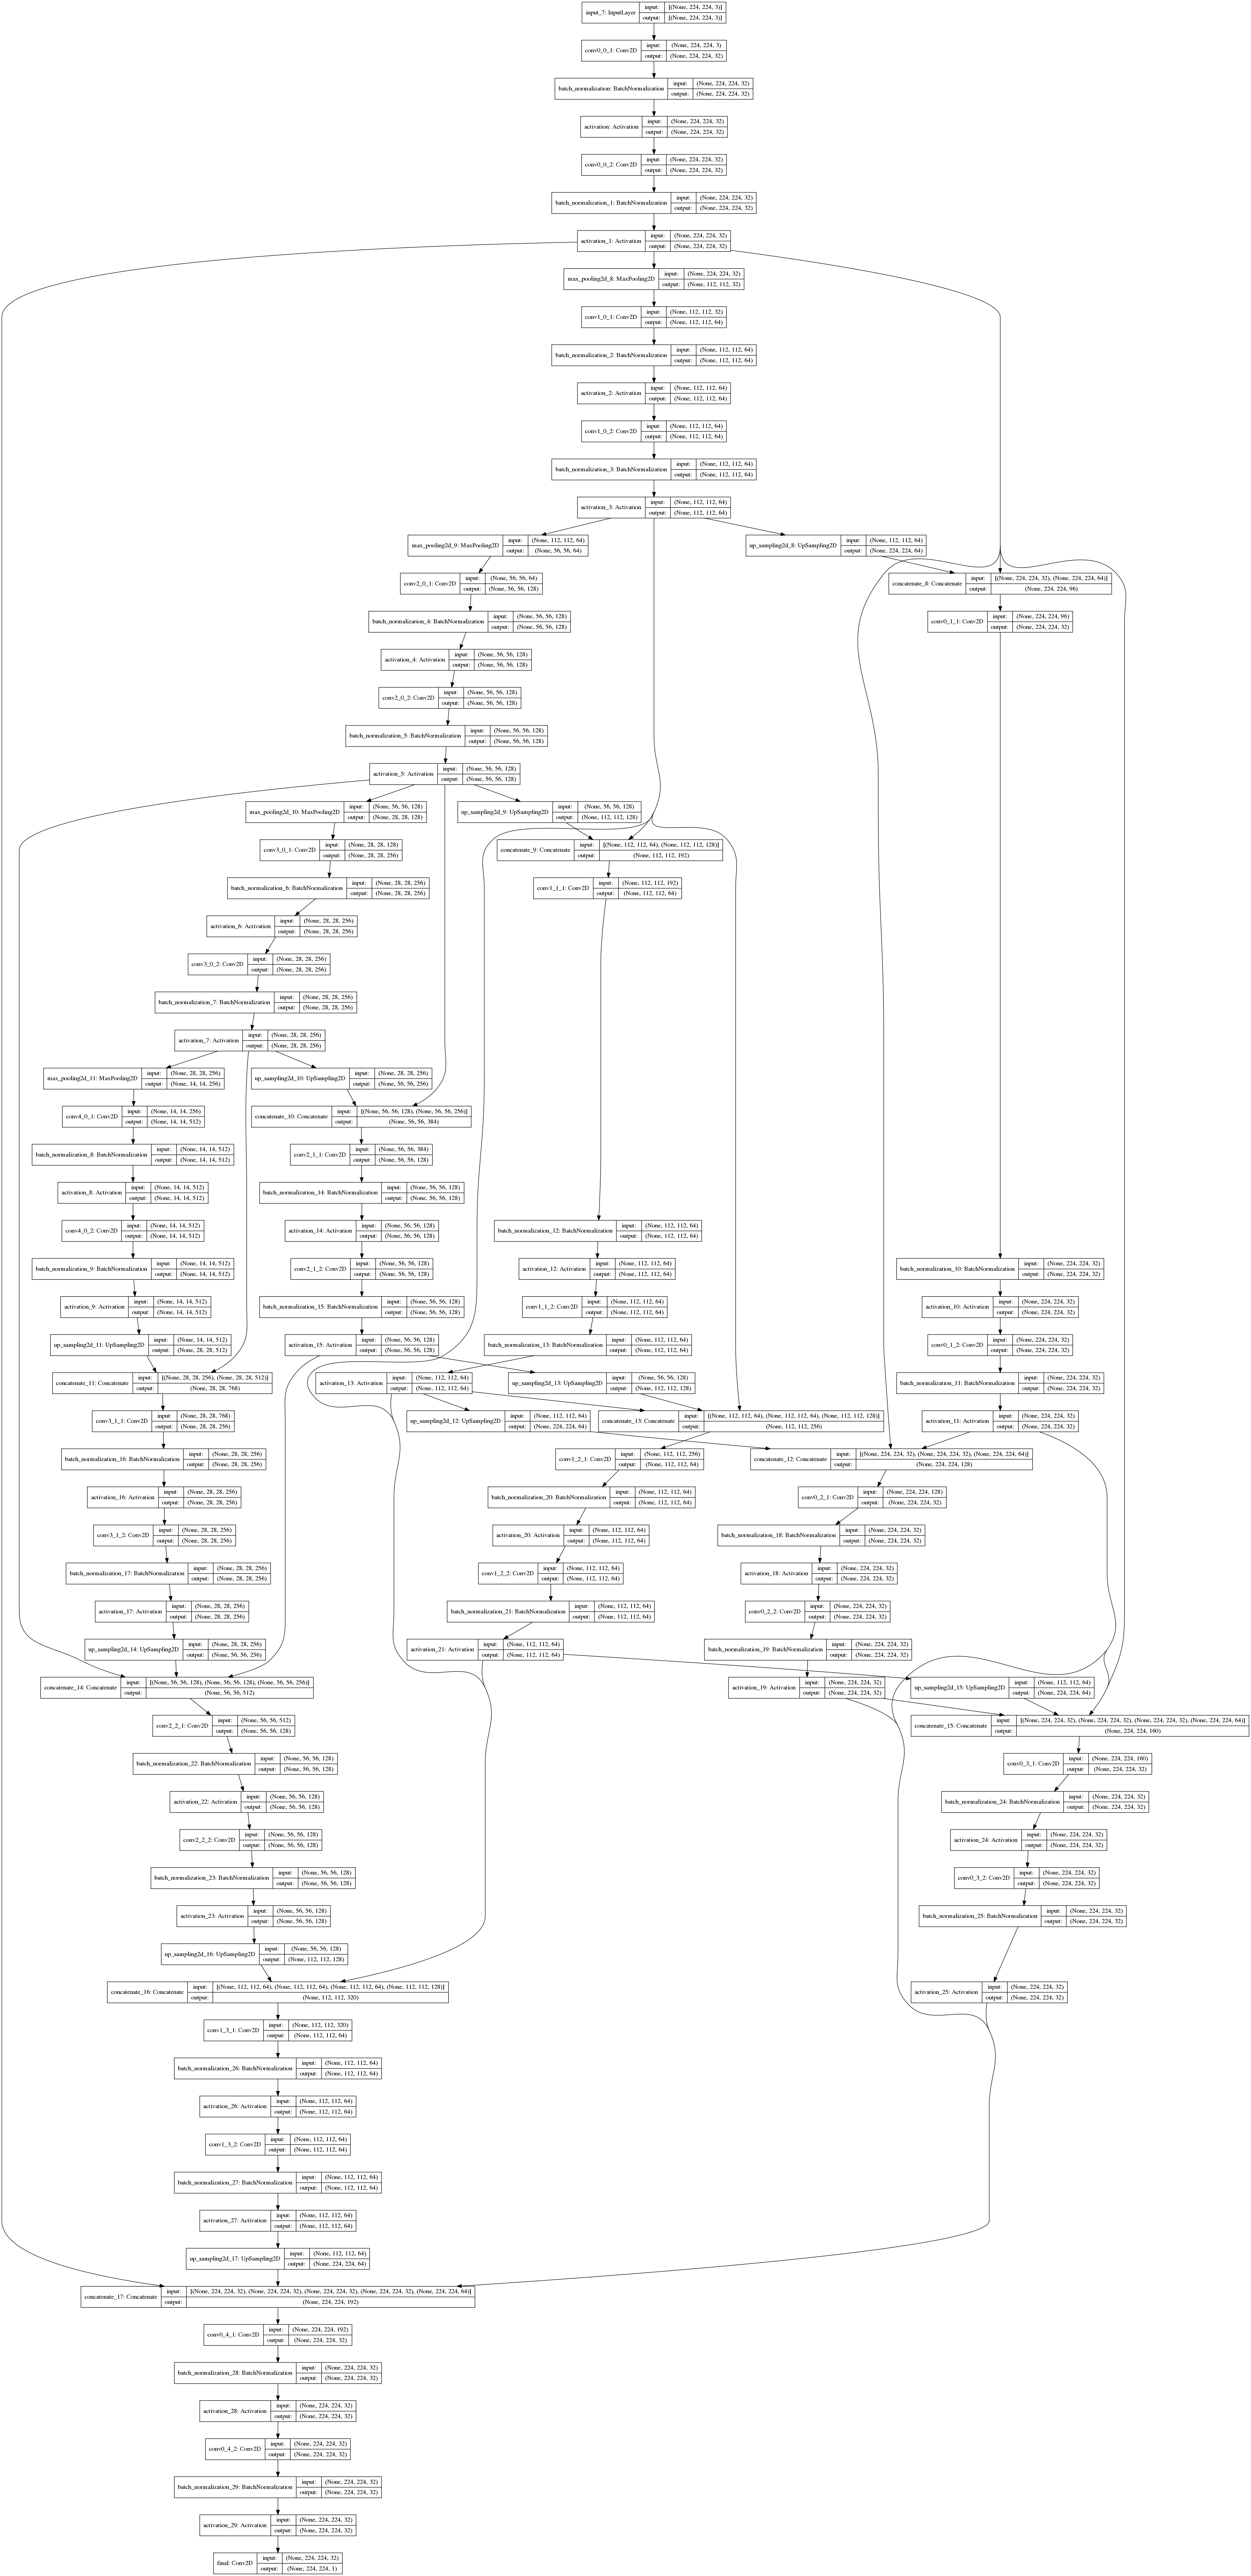

In [30]:
tf.keras.utils.plot_model(unet_pp, './UNet_Plus.png', show_shapes=True)

In [31]:
unet_pp.compile(
    optimizer = Adam(lr=1e-4),
    loss = 'binary_crossentropy'
             )

In [32]:
unet_pp.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100
)

Epoch 1/100
22/22 [==============================] - 46s 326ms/step - loss: 0.6070 - val_loss: 0.6091
Epoch 2/100
22/22 [==============================] - 7s 295ms/step - loss: 0.3679 - val_loss: 0.5277
Epoch 3/100
22/22 [==============================] - 7s 296ms/step - loss: 0.2977 - val_loss: 0.4934
Epoch 4/100
22/22 [==============================] - 7s 298ms/step - loss: 0.2440 - val_loss: 0.4242
Epoch 5/100
22/22 [==============================] - 7s 299ms/step - loss: 0.2078 - val_loss: 0.3492
Epoch 6/100
22/22 [==============================] - 7s 300ms/step - loss: 0.1755 - val_loss: 0.2901
Epoch 7/100
22/22 [==============================] - 7s 301ms/step - loss: 0.1704 - val_loss: 0.3013
Epoch 8/100
22/22 [==============================] - 7s 304ms/step - loss: 0.1556 - val_loss: 0.2667
Epoch 9/100
22/22 [==============================] - 7s 304ms/step - loss: 0.1516 - val_loss: 0.2072
Epoch 10/100
22/22 [==============================] - 7s 304ms/step - loss: 0.1302 - val_l

22/22 [==============================] - 7s 302ms/step - loss: 0.0320 - val_loss: 0.0654
Epoch 82/100
22/22 [==============================] - 7s 301ms/step - loss: 0.0293 - val_loss: 0.0352
Epoch 83/100
22/22 [==============================] - 7s 301ms/step - loss: 0.0295 - val_loss: 0.0743
Epoch 84/100
22/22 [==============================] - 7s 302ms/step - loss: 0.0346 - val_loss: 0.0699
Epoch 85/100
22/22 [==============================] - 7s 301ms/step - loss: 0.0337 - val_loss: 0.0530
Epoch 86/100
22/22 [==============================] - 7s 301ms/step - loss: 0.0331 - val_loss: 0.0343
Epoch 87/100
22/22 [==============================] - 7s 301ms/step - loss: 0.0381 - val_loss: 0.0313
Epoch 88/100
22/22 [==============================] - 7s 301ms/step - loss: 0.0270 - val_loss: 0.0408
Epoch 89/100
22/22 [==============================] - 7s 301ms/step - loss: 0.0304 - val_loss: 0.0553
Epoch 90/100
22/22 [==============================] - 7s 301ms/step - loss: 0.0313 - val_loss: 

In [33]:
unet_pp.save('./unet_pp.h5')

### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

In [34]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

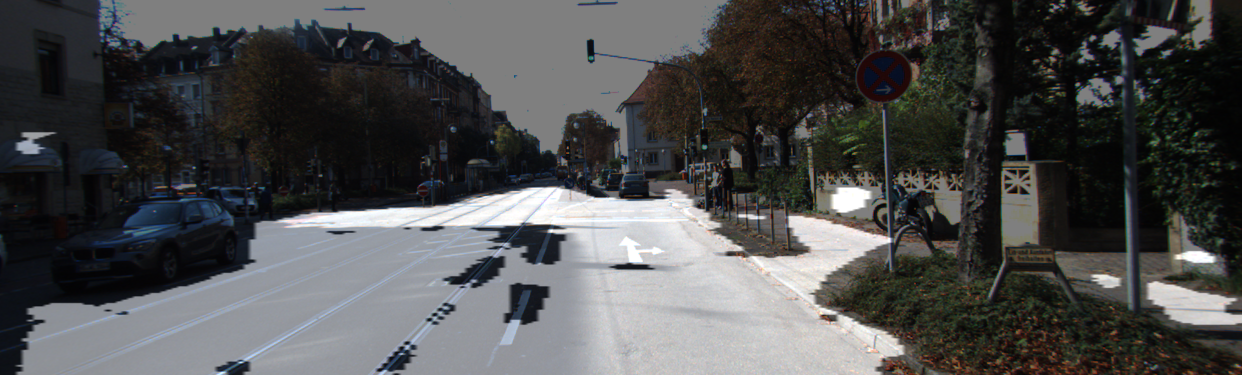

In [42]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

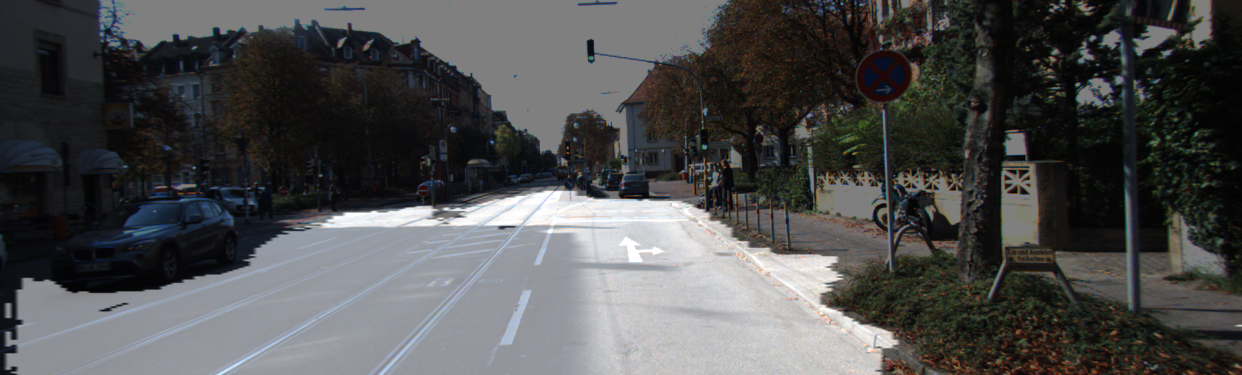

In [36]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [43]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [44]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [45]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.791365


0.7913653764355594

In [46]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.890194


0.8901937317675219

### 느낀점(회고)

U-Net의 경우 생각보다 잘 찾은 것 같지만 인도 영역까지 segmentation을 했다. 그에 반해 U-Net++는 인도를 제외한 도로의 영역만 찾아냈고 실제로 IoU수치도 약 0.1정도 U-Net++의 성능이 더 좋게 나왔다.